In [ ]:
# Install libraries (if needed)
# PyTorch comes pre-installed on Colab, no need to install separately

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Define transformations (convert images to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # mean and std for grayscale images
])

# Download the training and testing data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1 input channel (gray image), 32 output channels, 3x3 convolution
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)  # 2x2 pooling

        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After pooling twice, size reduces to 7x7
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
model = CNN()


In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Good for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()       # Clear gradients
        outputs = model(images)     # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()             # Backward pass
        optimizer.step()            # Update weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

print('Training Finished!')


Epoch 1, Loss: 0.1549
Epoch 2, Loss: 0.0455
Epoch 3, Loss: 0.0303
Epoch 4, Loss: 0.0224
Epoch 5, Loss: 0.0162
Training Finished!


In [ ]:
# Testing the model
correct = 0
total = 0

model.eval()  # Evaluation mode (important!)

with torch.no_grad():  # No gradients needed
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 99.05%


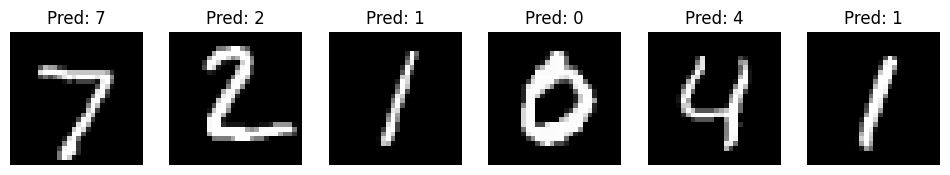

In [ ]:
# Visualize few test images and their predictions
import matplotlib.pyplot as plt

dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot images
fig, axes = plt.subplots(1, 6, figsize=(12, 4))
for idx in range(6):
    ax = axes[idx]
    ax.imshow(images[idx].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Pred: {predicted[idx].item()}")
    ax.axis('off')


In [ ]:
torch.save(model.state_dict(), 'mnist_cnn.pth')